In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions

import keras.layers
from keras.engine.topology import Input, Layer

from keras.models import Model, load_model
from keras import optimizers
import keras.backend
from keras import metrics
import keras.callbacks

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path 
import os

import PIL
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split

In [13]:
HOME_DIR = str(Path.home())
HICO_IMAGE_DIR = os.path.join(HOME_DIR, "projectdata/cht01/hico_20160224_det/images/train2015")

# Load training data

In [12]:
gt_data_path = os.path.join(HOME_DIR, "HICO/hico_det_dataset/anno_box_train.csv")
df_gt_data = pd.DataFrame.from_csv(gt_data_path)

# str to list
df_gt_data['human_bbox'] = df_gt_data['human_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
df_gt_data['obj_bbox'] = df_gt_data['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
df_gt_data['img_size_w_h'] = df_gt_data['img_size_w_h'].apply(lambda x: list(map(int,x.strip('[]').split(','))))

In [13]:
df_gt_data.head()

action_no           human_bbox   img_size_w_h                         name  \
0        153  [208, 427, 33, 300]  [640, 480, 3]  HICO_train2015_00000001.jpg   
1        154  [213, 438, 20, 357]  [640, 480, 3]  HICO_train2015_00000001.jpg   
2        155  [206, 427, 33, 306]  [640, 480, 3]  HICO_train2015_00000001.jpg   
3        156  [209, 444, 26, 317]  [640, 480, 3]  HICO_train2015_00000001.jpg   
4        224   [262, 638, 1, 138]  [640, 480, 3]  HICO_train2015_00000002.jpg   

               obj_bbox  
0    [59, 572, 98, 405]  
1   [77, 583, 115, 396]  
2   [61, 571, 100, 401]  
3    [59, 579, 99, 395]  
4  [162, 258, 131, 165]

# Get roi of feature map for each data

In [51]:
# # get each image size
# def GetImageSize(image_dir, image_name):
#     image_path = os.path.join(image_dir, image_name)
#     im = PIL.Image.open(image_path)
#     return im.size # (width,height) tuple

# df_gt_data['img_size_w_h'] = df_gt_data['name'].apply(lambda x: GetImageSize(HICO_IMAGE_DIR, x))

In [52]:
# df_gt_data.head()

action_no           human_bbox                         name  \
0        153  [208, 427, 33, 300]  HICO_train2015_00000001.jpg   
1        154  [213, 438, 20, 357]  HICO_train2015_00000001.jpg   
2        155  [206, 427, 33, 306]  HICO_train2015_00000001.jpg   
3        156  [209, 444, 26, 317]  HICO_train2015_00000001.jpg   
4        224   [262, 638, 1, 138]  HICO_train2015_00000002.jpg   

               obj_bbox img_size_w_h  
0    [59, 572, 98, 405]   (640, 480)  
1   [77, 583, 115, 396]   (640, 480)  
2   [61, 571, 100, 401]   (640, 480)  
3    [59, 579, 99, 395]   (640, 480)  
4  [162, 258, 131, 165]   (640, 480)

In [14]:
# get roi of feature map from bbox and image size
def GetFeatureMapRoi(img_size, img_bbox, feature_map_size):
    '''
    img_size : (w, h, d)
    img_bbox : (x1, x2, y1, y2)
    feature_map_size : (w, h)
    '''
    img_w, img_h = img_size[0], img_size[1]
    fm_w, fm_h = feature_map_size[0], feature_map_size[1]
    roi_x1 = (img_bbox[0] / img_w) * fm_w
    roi_x2 = (img_bbox[1] / img_w) * fm_w
    roi_y1 = (img_bbox[2] / img_h) * fm_h
    roi_y2 = (img_bbox[3] / img_h) * fm_h
    
    roi = np.round_((roi_x1, roi_x2, roi_y1, roi_y2), decimals=2)
    
    return roi.tolist()

In [15]:
feature_map_size = (4, 4)
df_gt_data['h_44_fm_roi'] = df_gt_data[['human_bbox', 'img_size_w_h']].apply(
    lambda x : GetFeatureMapRoi(x['img_size_w_h'], x['human_bbox'], feature_map_size), 
    axis=1)
df_gt_data['o_44_fm_roi'] = df_gt_data[['obj_bbox', 'img_size_w_h']].apply(
    lambda x : GetFeatureMapRoi(x['img_size_w_h'], x['obj_bbox'], feature_map_size), 
    axis=1)

In [16]:
df_gt_data.head()

action_no           human_bbox   img_size_w_h                         name  \
0        153  [208, 427, 33, 300]  [640, 480, 3]  HICO_train2015_00000001.jpg   
1        154  [213, 438, 20, 357]  [640, 480, 3]  HICO_train2015_00000001.jpg   
2        155  [206, 427, 33, 306]  [640, 480, 3]  HICO_train2015_00000001.jpg   
3        156  [209, 444, 26, 317]  [640, 480, 3]  HICO_train2015_00000001.jpg   
4        224   [262, 638, 1, 138]  [640, 480, 3]  HICO_train2015_00000002.jpg   

               obj_bbox               h_44_fm_roi               o_44_fm_roi  
0    [59, 572, 98, 405]    [1.3, 2.67, 0.28, 2.5]  [0.37, 3.58, 0.82, 3.38]  
1   [77, 583, 115, 396]  [1.33, 2.74, 0.17, 2.98]   [0.48, 3.64, 0.96, 3.3]  
2   [61, 571, 100, 401]  [1.29, 2.67, 0.28, 2.55]  [0.38, 3.57, 0.83, 3.34]  
3    [59, 579, 99, 395]  [1.31, 2.78, 0.22, 2.64]  [0.37, 3.62, 0.82, 3.29]  
4  [162, 258, 131, 165]  [1.64, 3.99, 0.01, 1.15]  [1.01, 1.61, 1.09, 1.38]

In [17]:
df_gt_data['h_44fm_roi_y1x1y2x2'] = df_gt_data['h_44_fm_roi'].apply(lambda x : [x[2], x[0], x[3], x[1]])
df_gt_data['o_44fm_roi_y1x1y2x2'] = df_gt_data['o_44_fm_roi'].apply(lambda x : [x[2], x[0], x[3], x[1]])
df_gt_data['h_44fm_roi_y1x1y2x2_norm'] = df_gt_data['h_44fm_roi_y1x1y2x2'].apply(
    lambda x : np.round(np.array(x)/4, decimals=3).tolist())
df_gt_data['o_44fm_roi_y1x1y2x2_norm'] = df_gt_data['o_44fm_roi_y1x1y2x2'].apply(
    lambda x : np.round(np.array(x)/4, decimals=3).tolist())

In [18]:
df_gt_data.head()

action_no           human_bbox   img_size_w_h                         name  \
0        153  [208, 427, 33, 300]  [640, 480, 3]  HICO_train2015_00000001.jpg   
1        154  [213, 438, 20, 357]  [640, 480, 3]  HICO_train2015_00000001.jpg   
2        155  [206, 427, 33, 306]  [640, 480, 3]  HICO_train2015_00000001.jpg   
3        156  [209, 444, 26, 317]  [640, 480, 3]  HICO_train2015_00000001.jpg   
4        224   [262, 638, 1, 138]  [640, 480, 3]  HICO_train2015_00000002.jpg   

               obj_bbox               h_44_fm_roi               o_44_fm_roi  \
0    [59, 572, 98, 405]    [1.3, 2.67, 0.28, 2.5]  [0.37, 3.58, 0.82, 3.38]   
1   [77, 583, 115, 396]  [1.33, 2.74, 0.17, 2.98]   [0.48, 3.64, 0.96, 3.3]   
2   [61, 571, 100, 401]  [1.29, 2.67, 0.28, 2.55]  [0.38, 3.57, 0.83, 3.34]   
3    [59, 579, 99, 395]  [1.31, 2.78, 0.22, 2.64]  [0.37, 3.62, 0.82, 3.29]   
4  [162, 258, 131, 165]  [1.64, 3.99, 0.01, 1.15]  [1.01, 1.61, 1.09, 1.38]   

        h_44fm_roi_y1x1y2x2       o_44fm_roi_y1x1y2x2  \
0    [0.28, 1.3, 2.5, 2.67]  [0.82, 0.37, 3.38, 3.58]   
1  [0.17, 1.33, 2.98, 2.74]   [0.96, 0.48, 3.3, 3.64]   
2  [0.28, 1.29, 2.55, 2.67]  [0.83, 0.38, 3.34, 3.57]   
3  [0.22, 1.31, 2.64, 2.78]  [0.82, 0.37, 3.29, 3.62]   
4  [0.01, 1.64, 1.15, 3.99]  [1.09, 1.01, 1.38, 1.61]   

       h_44fm_roi_y1x1y2x2_norm      o_44fm_roi_y1x1y2x2_norm  
0   [0.07, 0.325, 0.625, 0.668]  [0.205, 0.092, 0.845, 0.895]  
1  [0.042, 0.332, 0.745, 0.685]     [0.24, 0.12, 0.825, 0.91]  
2   [0.07, 0.322, 0.638, 0.668]  [0.208, 0.095, 0.835, 0.892]  
3   [0.055, 0.328, 0.66, 0.695]  [0.205, 0.092, 0.822, 0.905]  
4   [0.002, 0.41, 0.288, 0.998]  [0.272, 0.252, 0.345, 0.402]

In [19]:
df_gt_data.to_csv('final_train_data.csv')

# Load processed training data

In [3]:
df_gt_data = pd.DataFrame.from_csv('final_train_data.csv')

df_gt_data['human_bbox'] = df_gt_data['human_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
df_gt_data['obj_bbox'] = df_gt_data['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
df_gt_data['img_size_w_h'] = df_gt_data['img_size_w_h'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
df_gt_data['h_44fm_roi_y1x1y2x2_norm'] = df_gt_data['h_44fm_roi_y1x1y2x2_norm'].apply(lambda x: list(map(float,x.strip('[]').split(','))))
df_gt_data['o_44fm_roi_y1x1y2x2_norm'] = df_gt_data['o_44fm_roi_y1x1y2x2_norm'].apply(lambda x: list(map(float,x.strip('[]').split(','))))

df_gt_data.head()

action_no           human_bbox   img_size_w_h                         name  \
0        153  [208, 427, 33, 300]  [640, 480, 3]  HICO_train2015_00000001.jpg   
1        154  [213, 438, 20, 357]  [640, 480, 3]  HICO_train2015_00000001.jpg   
2        155  [206, 427, 33, 306]  [640, 480, 3]  HICO_train2015_00000001.jpg   
3        156  [209, 444, 26, 317]  [640, 480, 3]  HICO_train2015_00000001.jpg   
4        224   [262, 638, 1, 138]  [640, 480, 3]  HICO_train2015_00000002.jpg   

               obj_bbox               h_44_fm_roi               o_44_fm_roi  \
0    [59, 572, 98, 405]    [1.3, 2.67, 0.28, 2.5]  [0.37, 3.58, 0.82, 3.38]   
1   [77, 583, 115, 396]  [1.33, 2.74, 0.17, 2.98]   [0.48, 3.64, 0.96, 3.3]   
2   [61, 571, 100, 401]  [1.29, 2.67, 0.28, 2.55]  [0.38, 3.57, 0.83, 3.34]   
3    [59, 579, 99, 395]  [1.31, 2.78, 0.22, 2.64]  [0.37, 3.62, 0.82, 3.29]   
4  [162, 258, 131, 165]  [1.64, 3.99, 0.01, 1.15]  [1.01, 1.61, 1.09, 1.38]   

        h_44fm_roi_y1x1y2x2       o_44fm_roi_y1x1y2x2  \
0    [0.28, 1.3, 2.5, 2.67]  [0.82, 0.37, 3.38, 3.58]   
1  [0.17, 1.33, 2.98, 2.74]   [0.96, 0.48, 3.3, 3.64]   
2  [0.28, 1.29, 2.55, 2.67]  [0.83, 0.38, 3.34, 3.57]   
3  [0.22, 1.31, 2.64, 2.78]  [0.82, 0.37, 3.29, 3.62]   
4  [0.01, 1.64, 1.15, 3.99]  [1.09, 1.01, 1.38, 1.61]   

       h_44fm_roi_y1x1y2x2_norm      o_44fm_roi_y1x1y2x2_norm  
0   [0.07, 0.325, 0.625, 0.668]  [0.205, 0.092, 0.845, 0.895]  
1  [0.042, 0.332, 0.745, 0.685]     [0.24, 0.12, 0.825, 0.91]  
2   [0.07, 0.322, 0.638, 0.668]  [0.208, 0.095, 0.835, 0.892]  
3   [0.055, 0.328, 0.66, 0.695]  [0.205, 0.092, 0.822, 0.905]  
4   [0.002, 0.41, 0.288, 0.998]  [0.272, 0.252, 0.345, 0.402]

# Define custom layer

### RoI pooling layer

In [14]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    # Arguments
        pool_size: nxn region.
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(batch_size, image_height, image_width, image_channels)`
        X_roi:
        `(batch_size, 4)` list of rois, with ordering (y1, x1, y2, x2)
    # Output shape
        3D tensor with shape:
        `(batch_size, pool_size, pool_size, channels)`
    '''
    #参数定义
    def __init__(self, pool_size, **kwargs):
        self.pool_size = pool_size
        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]
        super(RoiPoolingConv, self).build(input_shape)  # Be sure to call this somewhere!

    def compute_output_shape(self, input_shape):
        return None, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2) # input is a list with 2 elements

        imgs = x[0]
        boxs = x[1]
        box_inds = tf.range(0, tf.shape(imgs)[0], delta=1) # create list [0, 1, ..., batch_size - 1]
        
        '''
        tf.image.crop_and_resize
        image : [batch_size, image_height, image_width, depth]
        boxes : [num_boxes, y1, x1, y2, x2]
        box_ind : [batch_size], image for i-th box
        '''
        # image 
        proc_imgs = tf.image.crop_and_resize(image=imgs, 
                                             boxes=boxs, 
                                             crop_size=[self.pool_size, self.pool_size], 
                                             box_ind=box_inds)
        
        return proc_imgs

    def get_config(self):
        config = {'pool_size': self.pool_size}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### LRN layer

In [15]:
class LRN(Layer):
    def __init__(self, n=5, alpha=0.0001, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
        if K.image_dim_ordering == "th":
            _, f, r, c = self.shape
        else:
            _, r, c, f = self.shape
        half_n = self.n // 2
        squared = K.square(x)

        pooled = K.pool2d(squared, (half_n, half_n), strides=(1, 1),padding="same",pool_mode="avg")
        if K.image_dim_ordering == "th":
            summed = K.sum(pooled, axis=1, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=1)
        else:
            summed = K.sum(pooled, axis=3, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom
    
    def get_output_shape_for(self, input_shape):
        return input_shape

# Build model

In [22]:
keras.backend.clear_session()

###  feature extraction CNN

In [17]:
cnn = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

image_cnn_input = cnn.input
image_cnn_ouput = cnn.output

### human stream

In [18]:
roi_h_input = Input(shape=(4,))

roi_pool_h = RoiPoolingConv(4)([image_cnn_ouput, roi_h_input])

flat_h = keras.layers.Flatten()(roi_pool_h)

fc1_h = keras.layers.Dense(4096, activation='selu')(flat_h)
fc2_h = keras.layers.Dense(4096, activation='selu')(fc1_h)

stream_score_h = keras.layers.Dense(600, activation=None)(fc2_h)

### object stream

In [19]:
roi_o_input = Input(shape=(4,))

roi_pool_o = RoiPoolingConv(4)([image_cnn_ouput, roi_o_input])

flat_o = keras.layers.Flatten()(roi_pool_o)

fc1_o = keras.layers.Dense(4096, activation='selu')(flat_o)
fc2_o = keras.layers.Dense(4096, activation='selu')(fc1_o)

stream_score_o = keras.layers.Dense(600, activation=None)(fc2_o)

### pairwise stream

In [20]:
pair_posi_input = Input(shape=(64, 64, 2))

conv1_p = keras.layers.Convolution2D(64, (5, 5), padding='same', activation='selu')(pair_posi_input)
#pool1p = ZeroPadding2D(padding=(2, 2))(conv1p) 
pool1_p = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv1_p)

conv2_p = keras.layers.Convolution2D(32, (5, 5), padding='same', activation='selu')(pool1_p)
pool2_p = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2_p)

flat_p = keras.layers.Flatten()(pool2_p)

fc1_p = keras.layers.Dense(256, activation='selu')(flat_p)

stream_score_p = keras.layers.Dense(600)(fc1_p)

### object detection score

In [21]:
obj_det_score_input  = Input(shape=(1,))
fc1_ods = keras.layers.Dense(80)(obj_det_score_input)
ods_score = keras.layers.Dense(600)(fc1_ods)

### add all stream score

In [37]:
total_score = keras.layers.Add()([stream_score_h, stream_score_o, stream_score_p, ods_score])
class_prob = keras.layers.Activation('sigmoid')(total_score)

## Create model

In [38]:
ho_rcnn_model = Model(inputs=[image_cnn_input, roi_h_input, roi_o_input, pair_posi_input, obj_det_score_input], 
                      outputs=[class_prob])

In [39]:
ho_rcnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

# Prepare training data

In [23]:
df_train_data = df_gt_data[['name',
                            'human_bbox',
                            'obj_bbox',
                            'h_44fm_roi_y1x1y2x2_norm', 
                            'o_44fm_roi_y1x1y2x2_norm', 
                            'action_no']]

In [24]:
df_train_data['score'] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_train_data.head()

name           human_bbox              obj_bbox  \
0  HICO_train2015_00000001.jpg  [208, 427, 33, 300]    [59, 572, 98, 405]   
1  HICO_train2015_00000001.jpg  [213, 438, 20, 357]   [77, 583, 115, 396]   
2  HICO_train2015_00000001.jpg  [206, 427, 33, 306]   [61, 571, 100, 401]   
3  HICO_train2015_00000001.jpg  [209, 444, 26, 317]    [59, 579, 99, 395]   
4  HICO_train2015_00000002.jpg   [262, 638, 1, 138]  [162, 258, 131, 165]   

       h_44fm_roi_y1x1y2x2_norm      o_44fm_roi_y1x1y2x2_norm  action_no  \
0   [0.07, 0.325, 0.625, 0.668]  [0.205, 0.092, 0.845, 0.895]        153   
1  [0.042, 0.332, 0.745, 0.685]     [0.24, 0.12, 0.825, 0.91]        154   
2   [0.07, 0.322, 0.638, 0.668]  [0.208, 0.095, 0.835, 0.892]        155   
3   [0.055, 0.328, 0.66, 0.695]  [0.205, 0.092, 0.822, 0.905]        156   
4   [0.002, 0.41, 0.288, 0.998]  [0.272, 0.252, 0.345, 0.402]        224   

   score  
0      1  
1      1  
2      1  
3      1  
4      1

## Define batch generator

In [26]:
"""
Create Pairwise human-object position image

Input:
box1: 4 np array with coordinates representing the first box {x11, y11, x12, y12}
box2: 4 np array with coordinates representing the second box {x21, y21, x22, y22}
length: scaling factor
        
Returns:
3D np array (2 x length x length), with the first dimension representing the filter 
on human, and the second dimension representing the filter on object 
"""

def get_map_n_pad(box1, box2, length):

    # get minimum x, y
    x_min = min(box1[0], box2[0])
    y_min = min(box1[1], box2[1])
    # translate
    bx1 = np.array([box1[0] - x_min, box1[1] - y_min,
                    box1[2] - x_min, box1[3] - y_min], dtype=np.float32)
    bx2 = np.array([box2[0] - x_min, box2[1] - y_min,
                    box2[2] - x_min, box2[3] - y_min], dtype=np.float32)
    # get new width and height
    w = max(bx1[2], bx2[2]) - min(bx1[0], bx2[0])
    h = max(bx1[3], bx2[3]) - min(bx1[1], bx2[1])
    # scale
    factor_w = np.float(length) / np.float(w)
    factor_h = np.float(length) / np.float(h)
    bx1_rs = np.array([bx1[0] * factor_w, bx1[1] * factor_h,
                       bx1[2] * factor_w, bx1[3] * factor_h])
    bx2_rs = np.array([bx2[0] * factor_w, bx2[1] * factor_h,
                       bx2[2] * factor_w, bx2[3] * factor_h])

    # generate map
    map_1 = np.zeros([length, length], dtype=np.uint8)
    map_2 = np.zeros([length, length], dtype=np.uint8)
    for i in range(int(round(bx1_rs[1])), int(round(bx1_rs[3]))):
        for j in range(int(round(bx1_rs[0])), int(round(bx1_rs[2]))):
            map_1[i][j] = 1
    for i in range(int(round(bx2_rs[1])), int(round(bx2_rs[3]))):
        for j in range(int(round(bx2_rs[0])), int(round(bx2_rs[2]))):
            map_2[i][j] = 1
    return np.array([map_1, map_2]), bx1_rs, bx2_rs

def get_map_w_pad(box1, box2, length):

    # get minimum x, y
    x_min = min(box1[0], box2[0])
    y_min = min(box1[1], box2[1])
    
    # translate
    bx1 = np.array([box1[0] - x_min, box1[1] - y_min,
                    box1[2] - x_min, box1[3] - y_min], dtype=np.float32)
    bx2 = np.array([box2[0] - x_min, box2[1] - y_min,
                    box2[2] - x_min, box2[3] - y_min], dtype=np.float32)

    # get new width and height
    w = max(bx1[2], bx2[2]) - min(bx1[0], bx2[0])
    h = max(bx1[3], bx2[3]) - min(bx1[1], bx2[1])
    # scale
    if h > w:
        factor = np.float(length) / np.float(h)
        num_pad = int(round((length - factor * w) / 2.0))
        bx1_rs = np.array([bx1[0] * factor + num_pad, bx1[1] * factor,
                           bx1[2] * factor + num_pad, bx1[3] * factor])
        bx2_rs = np.array([bx2[0] * factor + num_pad, bx2[1] * factor,
                           bx2[2] * factor + num_pad, bx2[3] * factor])
    else:
        factor = np.float(length) / np.float(w)
        num_pad = int(round((length - factor * h) / 2.0))
        bx1_rs = np.array([bx1[0] * factor, bx1[1] * factor + num_pad,
                           bx1[2] * factor, bx1[3] * factor + num_pad])
        bx2_rs = np.array([bx2[0] * factor, bx2[1] * factor + num_pad,
                           bx2[2] * factor, bx2[3] * factor + num_pad])

    # generate map
    map_1 = np.zeros([length, length], dtype=np.uint8)
    map_2 = np.zeros([length, length], dtype=np.uint8)
    for i in range(int(round(bx1_rs[1])), int(round(bx1_rs[3]))):
        for j in range(int(round(bx1_rs[0])), int(round(bx1_rs[2]))):
            map_1[i][j] = 1
    for i in range(int(round(bx2_rs[1])), int(round(bx2_rs[3]))):
        for j in range(int(round(bx2_rs[0])), int(round(bx2_rs[2]))):
            map_2[i][j] = 1
    return np.array([map_1, map_2]), bx1_rs, bx2_rs

In [27]:
# x: dataframe

# x_batch 要做成:
# [ img, h_fm_roi_y1x1y2x2_norm, o_fm_roi_y1x1y2x2_norm, pair_posi, score_o]

def batch_generator(x, pad, bs, shuffle=True):
    while (True):
        if(shuffle):
            new_ind = shuffle(range(x.shape[0])) # random_state=155
            x = x.take(new_ind)
        
        bat_img, bat_roi_o, bat_roi_h, bat_pair_posi, bat_score_o = [],[],[],[],[]
        bat_label = []
        for i in range(len(x)):
            row = x.iloc[i]
            
            # image
            img_path = os.path.join(HICO_IMAGE_DIR, row['name'])
            img = image.load_img(img_path, target_size=(224, 224, 3))
            img_arr = image.img_to_array(img)
            bat_img.append(img_arr)
            
            bat_roi_h.append(row['h_44fm_roi_y1x1y2x2_norm'])
            bat_roi_o.append(row['o_44fm_roi_y1x1y2x2_norm'])
            
            bat_score_o.append(row['score'])
            
            bat_label.append(row['action_no'])

            # pairwise stream data - with padding & without padding
            hum_bbox = row['human_bbox']
            obj_bbox = row['obj_bbox']
    
            hum_bbox_t = [hum_bbox[0], hum_bbox[2], hum_bbox[1], hum_bbox[3]]
            obj_bbox_t = [obj_bbox[0], obj_bbox[2], obj_bbox[1], obj_bbox[3]]    
            
            if pad == 0:
                pair_posi = get_map_n_pad(hum_bbox_t,obj_bbox_t, 64)
            elif pad == 1:
                pair_posi = get_map_w_pad(hum_bbox_t,obj_bbox_t, 64)
                
            pair_posi = pair_posi[0]
            pair_posi = pair_posi.swapaxes(0,1)
            pair_posi = pair_posi.swapaxes(1,2)
            bat_pair_posi.append(pair_posi)
        
            if ((i+1) % bs == 0):
                x_batch = [np.array(bat_img) / 255, 
                           np.array(bat_roi_h), 
                           np.array(bat_roi_o), 
                           np.array(bat_pair_posi),
                           np.array(bat_score_o)]
                
                batch_action = np.eye(600)[np.array(bat_label)]
                y_batch = [batch_action]
                
                bat_img, bat_roi_o, bat_roi_h, bat_pair_posi, bat_score_o = [],[],[],[],[]
                bat_label = []
                
                yield (x_batch, y_batch) 

# Train model

In [28]:
import keras.backend as K
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
            return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def top_n_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [29]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
ho_rcnn_model.compile(loss='binary_crossentropy', # loss=[focal_loss(alpha=.25, gamma=2)]
              optimizer=opt,
              metrics=[top_n_accuracy])

NameError: name 'ho_rcnn_model' is not defined

### fit batch

In [46]:
gen = batch_generator(x=df_train_data, pad=1, bs=100)
batch = next(gen)

# input image
batch_imgs = batch[0][0]
print('image:', batch_imgs.shape)

batch_rois_h = batch[0][1]
print('roi human: ', batch_rois_h.shape)

batch_rois_o = batch[0][2]
print('roi object: ', batch_rois_o.shape)

batch_pair_posi = batch[0][3]
print('pair position: ', batch_pair_posi.shape)

batch_obj_det_s = batch[0][4]
print('obj det score: ', batch_obj_det_s.shape)

batch_action = batch[1][0]
# print(batch_action.argmax(axis=1))
print('label: ', batch_action.shape)

image: (100, 224, 224, 3)
roi human:  (100, 4)
roi object:  (100, 4)
pair position:  (100, 64, 64, 2)
obj det score:  (100,)
label:  (100, 600)


In [47]:
# Model(inputs=[image_cnn_input, roi_h_input, roi_o_input], outputs=[class_prob])
ho_rcnn_model.fit(x=batch[0], 
                  y=batch[1],
                  epochs=50)

Epoch 1/50
100/100 [==============================] - 5s 54ms/step - loss: 0.4092 - top_n_accuracy: 0.0100
Epoch 2/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0137 - top_n_accuracy: 0.0500
Epoch 3/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0134 - top_n_accuracy: 0.0600
Epoch 4/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0113 - top_n_accuracy: 0.0900
Epoch 5/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0103 - top_n_accuracy: 0.0700
Epoch 6/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0097 - top_n_accuracy: 0.0800
Epoch 7/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0091 - top_n_accuracy: 0.1400
Epoch 8/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0090 - top_n_accuracy: 0.1100
Epoch 9/50
100/100 [==============================] - 1s 12ms/step - loss: 0.0087 - top_n_accuracy: 0.0900
Epoch 10/50
100/100 [================

In [49]:
pred = ho_rcnn_model.predict(x=batch[0])
top_k = np.argsort(pred, axis=1)[:,-1:-4:-1]
gt = batch[1][0].argmax(axis=1)

pd.DataFrame({'a':top_k.tolist(), 'b':gt.tolist()})

a    b
0     [109, 57, 40]  109
1   [224, 590, 209]  224
2    [155, 24, 142]  155
3    [578, 286, 42]  578
4   [141, 142, 155]  141
5    [186, 249, 12]  186
6   [296, 590, 279]   79
7   [372, 209, 109]  372
8    [40, 538, 241]   40
9      [61, 57, 62]   61
10  [472, 321, 473]  472
11  [259, 458, 279]  259
12   [509, 494, 12]  509
13  [110, 109, 142]  110
14   [142, 57, 109]  142
15  [109, 110, 472]  109
16    [106, 24, 37]  106
17  [466, 259, 209]  466
18    [12, 19, 155]   12
19  [534, 494, 156]  534
20    [40, 517, 43]   40
21  [472, 471, 462]  472
22    [57, 61, 109]   61
23     [37, 61, 57]   37
24   [40, 517, 109]   40
25    [99, 246, 12]   99
26   [533, 20, 198]  533
27  [285, 494, 462]  285
28  [343, 186, 170]  343
29   [142, 155, 19]  142
..              ...  ...
70  [279, 494, 590]  279
71  [213, 209, 234]  213
72  [246, 494, 156]  246
73   [246, 110, 12]  246
74   [384, 20, 570]  384
75  [170, 296, 371]  170
76  [251, 259, 297]  251
77   [19, 473, 494]   19
78   [462, 19, 458]  462
79    [42, 57, 155]   42
80  [297, 496, 267]  297
81  [577, 494, 252]  577
82   [567, 43, 462]  567
83   [12, 509, 156]   12
84   [42, 110, 477]   42
85   [198, 42, 533]  198
86  [371, 343, 533]  371
87   [241, 578, 42]  241
88  [252, 494, 534]  252
89   [24, 109, 106]   24
90     [55, 61, 42]   55
91  [471, 472, 141]  471
92  [249, 246, 156]  249
93  [590, 494, 224]  590
94  [458, 494, 209]  458
95  [458, 259, 496]  458
96  [545, 209, 534]  545
97  [269, 494, 297]  269
98    [246, 99, 12]  246
99   [477, 42, 458]  477

[100 rows x 2 columns]

### fit generator

In [64]:
train_data, validate_data = train_test_split(df_train_data, test_size=0.2, random_state=6)
print(train_data.shape)
print(validate_data.shape)

(94296, 7)
(23575, 7)


In [69]:
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
ho_rcnn_model.fit_generator(batch_generator(x=train_data, pad=1, bs=50),
                    steps_per_epoch=100,
                    epochs=5,
                    validation_data=(batch_generator(x=validate_data, pad=1, bs=50)),
                    validation_steps=10,
                    workers=4,
#                     callbacks=[earlystop]
                   )

Epoch 1/5
100/100 [==============================] - 56s 558ms/step - loss: 0.0075 - top_n_accuracy: 0.4306 - val_loss: 0.0080 - val_top_n_accuracy: 0.3780
Epoch 2/5
100/100 [==============================] - 56s 561ms/step - loss: 0.0075 - top_n_accuracy: 0.4426 - val_loss: 0.0078 - val_top_n_accuracy: 0.3960
Epoch 3/5
100/100 [==============================] - 56s 562ms/step - loss: 0.0074 - top_n_accuracy: 0.4456 - val_loss: 0.0077 - val_top_n_accuracy: 0.4260
Epoch 4/5
100/100 [==============================] - 56s 563ms/step - loss: 0.0074 - top_n_accuracy: 0.4510 - val_loss: 0.0074 - val_top_n_accuracy: 0.4340
Epoch 5/5
100/100 [==============================] - 56s 561ms/step - loss: 0.0073 - top_n_accuracy: 0.4594 - val_loss: 0.0079 - val_top_n_accuracy: 0.4340


### save model

In [70]:
import datetime
import time

ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S')
ho_rcnn_model.save('ho_rcnn_model_model_{}.h5'.format(st))

### load model

In [30]:
ho_rcnn_model = load_model('ho_rcnn_model_model_20180426_022648.h5', 
                           custom_objects={'RoiPoolingConv':RoiPoolingConv, 'top_n_accuracy':top_n_accuracy})

### test model

In [58]:
batch_size = 40
df_bat = df_train_data.iloc[:40]

bat = next(batch_generator(x=df_bat, pad=1, bs=batch_size, shuffle=False))
test_input = bat[0]
test_gt = bat[1][0].argmax(axis=1)

In [59]:
k=5
pred = ho_rcnn_model.predict(test_input)
top_k = np.argsort(pred, axis=1)[:,-1:-(k+1):-1]
top_k_prob = np.sort(pred, axis=1)[:,-1:-(k+1):-1]

res_table = pd.DataFrame({'top_k':top_k.tolist(), 'top_k_prob':top_k_prob.tolist(), 'gt':test_gt.tolist()})
res_table['is_correct'] = res_table.apply(lambda x: x['gt'] in x['top_k'] ,axis=1)

df_bat = pd.concat([df_bat, res_table], axis=1)
df_bat.head()

name           human_bbox              obj_bbox  \
0  HICO_train2015_00000001.jpg  [208, 427, 33, 300]    [59, 572, 98, 405]   
1  HICO_train2015_00000001.jpg  [213, 438, 20, 357]   [77, 583, 115, 396]   
2  HICO_train2015_00000001.jpg  [206, 427, 33, 306]   [61, 571, 100, 401]   
3  HICO_train2015_00000001.jpg  [209, 444, 26, 317]    [59, 579, 99, 395]   
4  HICO_train2015_00000002.jpg   [262, 638, 1, 138]  [162, 258, 131, 165]   

       h_44fm_roi_y1x1y2x2_norm      o_44fm_roi_y1x1y2x2_norm  action_no  \
0   [0.07, 0.325, 0.625, 0.668]  [0.205, 0.092, 0.845, 0.895]        153   
1  [0.042, 0.332, 0.745, 0.685]     [0.24, 0.12, 0.825, 0.91]        154   
2   [0.07, 0.322, 0.638, 0.668]  [0.208, 0.095, 0.835, 0.892]        155   
3   [0.055, 0.328, 0.66, 0.695]  [0.205, 0.092, 0.822, 0.905]        156   
4   [0.002, 0.41, 0.288, 0.998]  [0.272, 0.252, 0.345, 0.402]        224   

   score   gt                      top_k  \
0      1  153  [154, 155, 147, 156, 134]   
1      1  154  [155, 154, 156, 147, 153]   
2      1  155  [154, 155, 147, 156, 134]   
3      1  156  [155, 154, 147, 156, 153]   
4      1  224  [429, 381, 273, 595, 378]   

                                          top_k_prob is_correct  
0  [0.2664232850074768, 0.242308109998703, 0.1902...      False  
1  [0.6120561957359314, 0.3466106951236725, 0.229...       True  
2  [0.29547998309135437, 0.27527204155921936, 0.1...       True  
3  [0.3145124912261963, 0.2785852551460266, 0.145...       True  
4  [0.7473322749137878, 0.20762380957603455, 0.12...      False

HICO_train2015_00000001.jpg
gt: race / motorcycle
pred: ride / motorcycle / 0.2664232850074768
pred: sit_on / motorcycle / 0.242308109998703
pred: hold / motorcycle / 0.1902252733707428
pred: straddle / motorcycle / 0.1041688323020935
pred: jump / horse / 0.0474112443625927


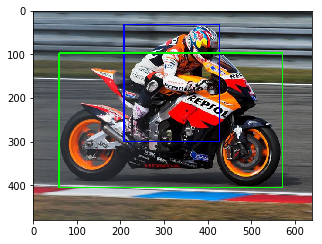

HICO_train2015_00000001.jpg
gt: ride / motorcycle
pred: sit_on / motorcycle / 0.6120561957359314
pred: ride / motorcycle / 0.3466106951236725
pred: straddle / motorcycle / 0.22994457185268402
pred: hold / motorcycle / 0.20384719967842102
pred: race / motorcycle / 0.042736075818538666


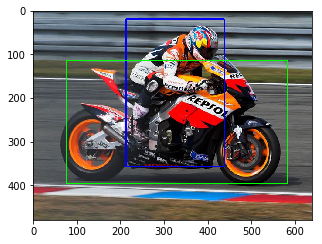

HICO_train2015_00000001.jpg
gt: sit_on / motorcycle
pred: ride / motorcycle / 0.29547998309135437
pred: sit_on / motorcycle / 0.27527204155921936
pred: hold / motorcycle / 0.19535724818706512
pred: straddle / motorcycle / 0.11398494243621826
pred: jump / horse / 0.041953153908252716


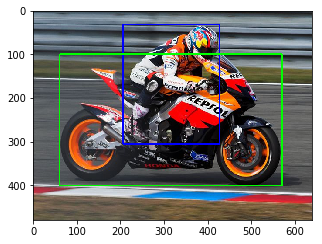

HICO_train2015_00000001.jpg
gt: straddle / motorcycle
pred: sit_on / motorcycle / 0.3145124912261963
pred: ride / motorcycle / 0.2785852551460266
pred: hold / motorcycle / 0.14518830180168152
pred: straddle / motorcycle / 0.10532540082931519
pred: race / motorcycle / 0.038409702479839325


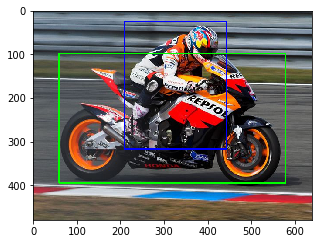

HICO_train2015_00000002.jpg
gt: no_interaction / banana
pred: no_interaction / pizza / 0.7473322749137878
pred: wield / knife / 0.20762380957603455
pred: no_interaction / cake / 0.12352783232927322
pred: no_interaction / wine_glass / 0.09926019608974457
pred: hold / knife / 0.0796286091208458


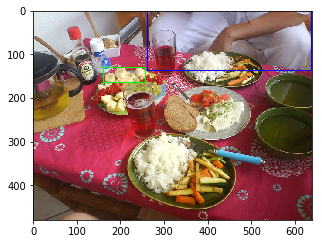

HICO_train2015_00000003.jpg
gt: no_interaction / bus
pred: no_interaction / bus / 0.1687464565038681
pred: sit_on / bus / 0.15333394706249237
pred: board / bus / 0.07392407953739166
pred: no_interaction / person / 0.06715551763772964
pred: watch / elephant / 0.04691527783870697


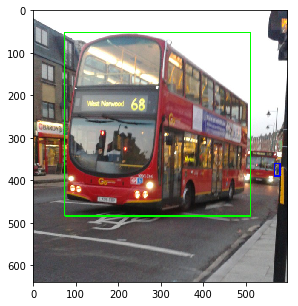

HICO_train2015_00000004.jpg
gt: drink_with / bottle
pred: swing / baseball_bat / 0.14568102359771729
pred: hold / baseball_bat / 0.13719283044338226
pred: talk_on / cell_phone / 0.10930769890546799
pred: hold / cell_phone / 0.059870846569538116
pred: wield / baseball_bat / 0.04868600144982338


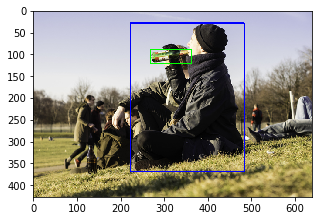

HICO_train2015_00000004.jpg
gt: hold / bottle
pred: swing / baseball_bat / 0.1546110212802887
pred: hold / baseball_bat / 0.15382592380046844
pred: talk_on / cell_phone / 0.10052460432052612
pred: hold / cell_phone / 0.06150443106889725
pred: wield / baseball_bat / 0.056917037814855576


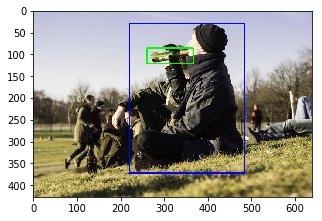

HICO_train2015_00000005.jpg
gt: sit_on / bed
pred: sit_at / dining_table / 0.25600364804267883
pred: eat_at / dining_table / 0.18016426265239716
pred: sit_on / motorcycle / 0.02068834751844406
pred: lie_on / bed / 0.020490344613790512
pred: hold / motorcycle / 0.0170820914208889


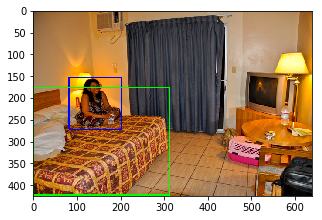

HICO_train2015_00000006.jpg
gt: hold / umbrella
pred: stand_under / umbrella / 0.6657068133354187
pred: hold / umbrella / 0.26818856596946716
pred: carry / umbrella / 0.23431222140789032
pred: hold / knife / 0.04503071308135986
pred: wield / knife / 0.040947433561086655


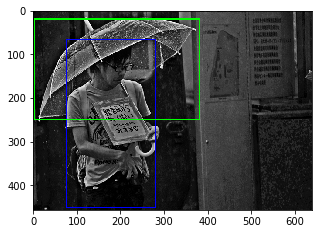

HICO_train2015_00000006.jpg
gt: stand_under / umbrella
pred: stand_under / umbrella / 0.7191828489303589
pred: carry / umbrella / 0.16970710456371307
pred: hold / umbrella / 0.16242164373397827
pred: sit_on / couch / 0.07351267337799072
pred: wield / knife / 0.07248250395059586


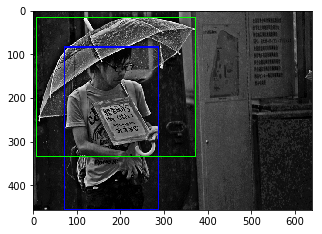

HICO_train2015_00000007.jpg
gt: no_interaction / pizza
pred: no_interaction / pizza / 0.3591019809246063
pred: no_interaction / sheep / 0.21899689733982086
pred: no_interaction / laptop / 0.16754165291786194
pred: no_interaction / dining_table / 0.15737925469875336
pred: hold / sheep / 0.10267031192779541


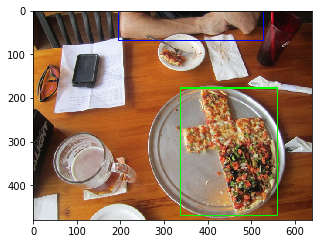

HICO_train2015_00000008.jpg
gt: brush_with / toothbrush
pred: brush_with / toothbrush / 0.21993966400623322
pred: hold / wine_glass / 0.17419791221618652
pred: blow / cake / 0.14701732993125916
pred: no_interaction / person / 0.11537980288267136
pred: eat / cake / 0.10886982083320618


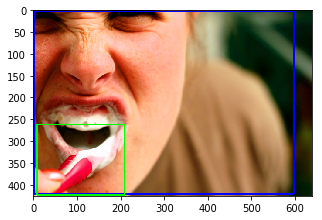

HICO_train2015_00000008.jpg
gt: hold / toothbrush
pred: brush_with / toothbrush / 0.2392301708459854
pred: blow / cake / 0.19661349058151245
pred: hold / wine_glass / 0.1528199017047882
pred: eat / cake / 0.15093642473220825
pred: no_interaction / person / 0.05357205867767334


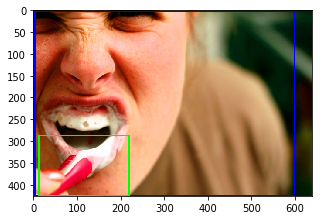

HICO_train2015_00000009.jpg
gt: load / truck
pred: hold / horse / 0.07950517535209656
pred: sit_on / motorcycle / 0.0575907938182354
pred: no_interaction / person / 0.05737568065524101
pred: sit_on / bench / 0.0462297722697258
pred: sit_at / dining_table / 0.027459755539894104


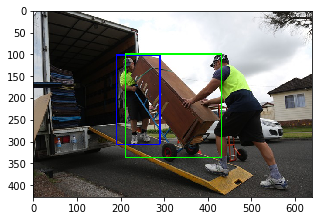

HICO_train2015_00000009.jpg
gt: load / truck
pred: hold / person / 0.1221776232123375
pred: hold / surfboard / 0.0333077572286129
pred: wear / backpack / 0.031880807131528854
pred: hold / umbrella / 0.02687673643231392
pred: carry / tennis_racket / 0.02231619507074356


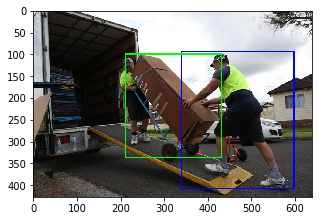

HICO_train2015_00000010.jpg
gt: hold / horse
pred: ride / horse / 0.35908496379852295
pred: hold / horse / 0.24139529466629028
pred: straddle / horse / 0.21274767816066742
pred: run / horse / 0.07108847051858902
pred: no_interaction / person / 0.0613219253718853


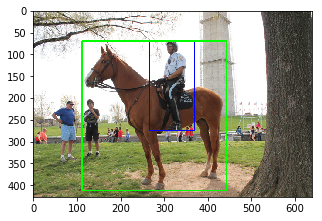

HICO_train2015_00000010.jpg
gt: ride / horse
pred: ride / horse / 0.3263408839702606
pred: straddle / horse / 0.22994376718997955
pred: hold / horse / 0.19662384688854218
pred: no_interaction / person / 0.09987955540418625
pred: run / horse / 0.05722210556268692


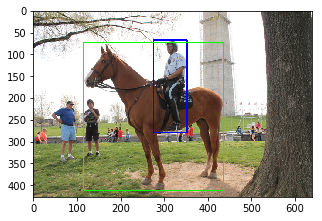

HICO_train2015_00000010.jpg
gt: straddle / horse
pred: ride / horse / 0.1883290410041809
pred: straddle / horse / 0.15563131868839264
pred: hold / horse / 0.14404696226119995
pred: no_interaction / person / 0.14005346596240997
pred: walk / horse / 0.05005323514342308


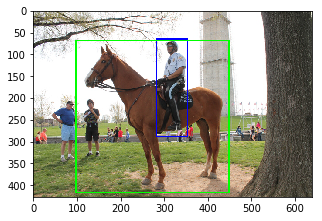

HICO_train2015_00000011.jpg
gt: carry / backpack
pred: read / book / 0.08558209240436554
pred: carry / backpack / 0.058355215936899185
pred: wear / backpack / 0.05748894810676575
pred: hold / cell_phone / 0.03551678732037544
pred: carry / umbrella / 0.03502405062317848


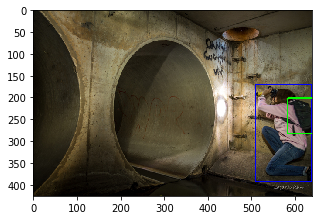

HICO_train2015_00000011.jpg
gt: wear / backpack
pred: wear / backpack / 0.3331075608730316
pred: carry / backpack / 0.23705092072486877
pred: read / book / 0.09661652892827988
pred: carry / umbrella / 0.052525684237480164
pred: sit_on / chair / 0.04032488539814949


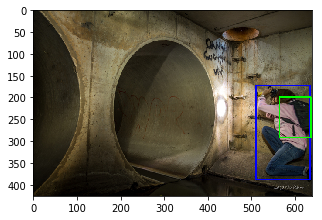

HICO_train2015_00000012.jpg
gt: hold / umbrella
pred: stand_under / umbrella / 0.6668172478675842
pred: hold / umbrella / 0.508545458316803
pred: carry / umbrella / 0.2664399743080139
pred: no_interaction / umbrella / 0.028363997116684914
pred: watch / giraffe / 0.01568310707807541


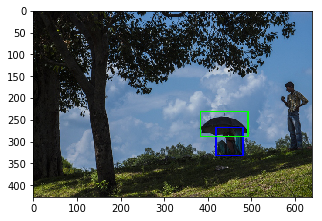

HICO_train2015_00000013.jpg
gt: cut / carrot
pred: watch / giraffe / 0.43605607748031616
pred: stand_under / umbrella / 0.22901003062725067
pred: hold / umbrella / 0.10665792226791382
pred: pet / elephant / 0.10615331679582596
pred: no_interaction / bus / 0.08513369411230087


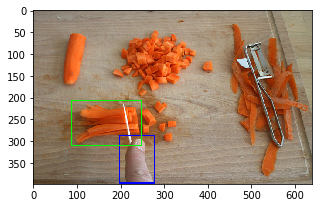

HICO_train2015_00000015.jpg
gt: hold / bicycle
pred: straddle / bicycle / 0.10486514121294022
pred: ride / bicycle / 0.08972007036209106
pred: hold / bicycle / 0.07653173804283142
pred: sit_on / bicycle / 0.07225356996059418
pred: hold / motorcycle / 0.04595308005809784


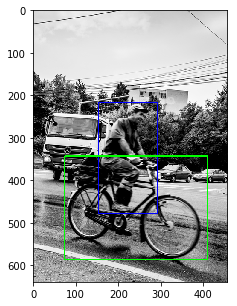

HICO_train2015_00000015.jpg
gt: ride / bicycle
pred: ride / bicycle / 0.08755980432033539
pred: straddle / bicycle / 0.08212766796350479
pred: sit_on / bicycle / 0.0762203186750412
pred: hold / bicycle / 0.06535818427801132
pred: hold / motorcycle / 0.05780954658985138


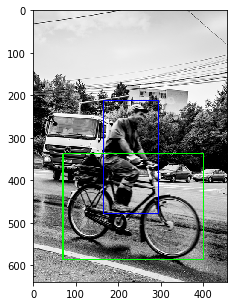

HICO_train2015_00000015.jpg
gt: sit_on / bicycle
pred: straddle / bicycle / 0.13847939670085907
pred: ride / bicycle / 0.12565304338932037
pred: hold / bicycle / 0.09448720514774323
pred: sit_on / bicycle / 0.0780293419957161
pred: hold / motorcycle / 0.0492168590426445


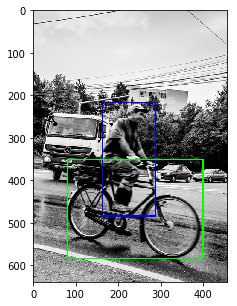

HICO_train2015_00000015.jpg
gt: straddle / bicycle
pred: straddle / bicycle / 0.159527987241745
pred: ride / bicycle / 0.14476646482944489
pred: hold / bicycle / 0.12994979321956635
pred: sit_on / bicycle / 0.09619320183992386
pred: sit_on / motorcycle / 0.08650486916303635


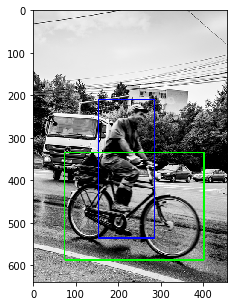

HICO_train2015_00000016.jpg
gt: watch / tv
pred: no_interaction / bicycle / 0.12100056558847427
pred: no_interaction / bus / 0.08617622405290604
pred: board / bus / 0.04529031366109848
pred: drive / train / 0.03607576712965965
pred: watch / giraffe / 0.03007100336253643


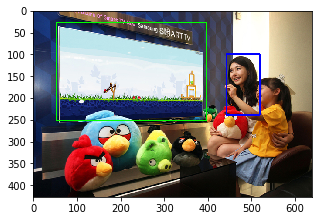

HICO_train2015_00000016.jpg
gt: watch / tv
pred: watch / giraffe / 0.6403244137763977
pred: feed / giraffe / 0.3069627285003662
pred: no_interaction / tv / 0.10569622367620468
pred: watch / bear / 0.0587800107896328
pred: no_interaction / bottle / 0.042624738067388535


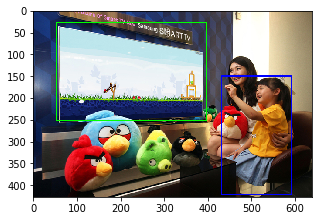

HICO_train2015_00000017.jpg
gt: eat_at / dining_table
pred: sit_at / dining_table / 0.4133579134941101
pred: eat_at / dining_table / 0.19636276364326477
pred: sit_on / couch / 0.023993810638785362
pred: no_interaction / dining_table / 0.016308145597577095
pred: sit_on / bench / 0.012994839809834957


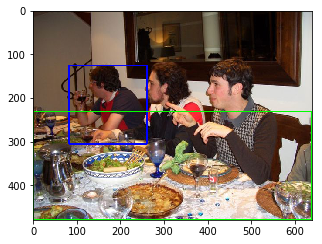

HICO_train2015_00000017.jpg
gt: eat_at / dining_table
pred: sit_at / dining_table / 0.22629021108150482
pred: eat_at / dining_table / 0.10681242495775223
pred: sit_on / couch / 0.03472743183374405
pred: lie_on / bed / 0.027722006663680077
pred: sit_on / bicycle / 0.011500990949571133


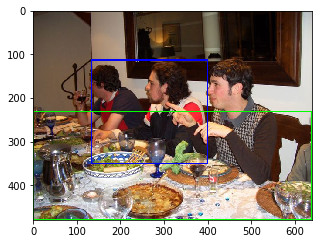

HICO_train2015_00000017.jpg
gt: eat_at / dining_table
pred: sit_at / dining_table / 0.46369701623916626
pred: eat_at / dining_table / 0.09359750896692276
pred: sit_on / couch / 0.08439275622367859
pred: sit_on / bench / 0.02827533893287182
pred: lie_on / bed / 0.014077949337661266


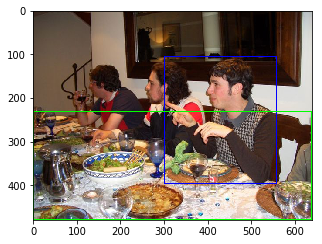

HICO_train2015_00000017.jpg
gt: sit_at / dining_table
pred: sit_at / dining_table / 0.5130765438079834
pred: eat_at / dining_table / 0.08107674866914749
pred: watch / giraffe / 0.0345364548265934
pred: sit_on / bus / 0.03136622905731201
pred: sit_on / couch / 0.01675574667751789


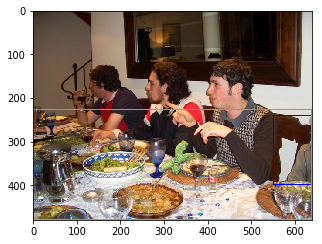

HICO_train2015_00000017.jpg
gt: sit_at / dining_table
pred: sit_at / dining_table / 0.4362391233444214
pred: eat_at / dining_table / 0.20570945739746094
pred: no_interaction / dining_table / 0.025353895500302315
pred: sit_on / couch / 0.022586459293961525
pred: sit_on / bench / 0.011316527612507343


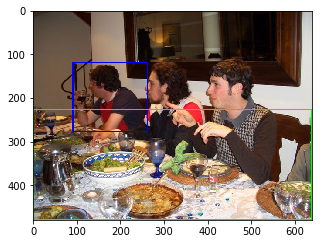

HICO_train2015_00000017.jpg
gt: sit_at / dining_table
pred: sit_at / dining_table / 0.253400981426239
pred: eat_at / dining_table / 0.1012042835354805
pred: sit_on / couch / 0.037327077239751816
pred: lie_on / bed / 0.02800639532506466
pred: sit_on / bench / 0.011351621709764004


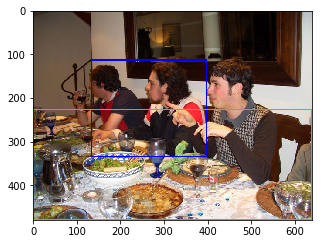

HICO_train2015_00000017.jpg
gt: sit_at / dining_table
pred: sit_at / dining_table / 0.45095309615135193
pred: sit_on / couch / 0.10290615260601044
pred: eat_at / dining_table / 0.07782536745071411
pred: sit_on / bench / 0.03272179514169693
pred: lie_on / bed / 0.014791625551879406


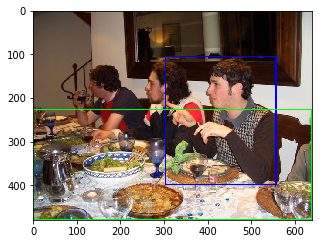

HICO_train2015_00000018.jpg
gt: fill / wine_glass
pred: hold / knife / 0.09796120226383209
pred: wield / knife / 0.06824860721826553
pred: eat / cake / 0.052390314638614655
pred: hold / cell_phone / 0.036195505410432816
pred: hold / scissors / 0.034269124269485474


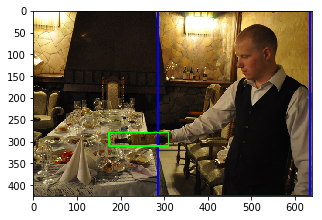

HICO_train2015_00000019.jpg
gt: hold / bicycle
pred: straddle / bicycle / 0.05898706614971161
pred: sit_on / bicycle / 0.03854861110448837
pred: ride / bicycle / 0.03364454582333565
pred: sit_on / motorcycle / 0.02917182259261608
pred: eat_at / dining_table / 0.02781669795513153


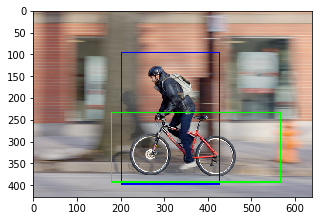

HICO_train2015_00000019.jpg
gt: ride / bicycle
pred: straddle / bicycle / 0.5148504972457886
pred: ride / bicycle / 0.35403355956077576
pred: sit_on / bicycle / 0.33487987518310547
pred: hold / bicycle / 0.16226482391357422
pred: hold / motorcycle / 0.03735273331403732


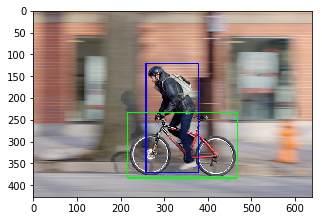

HICO_train2015_00000019.jpg
gt: straddle / bicycle
pred: straddle / bicycle / 0.4786498248577118
pred: ride / bicycle / 0.3315342366695404
pred: sit_on / bicycle / 0.31885242462158203
pred: hold / bicycle / 0.14144934713840485
pred: hold / motorcycle / 0.04218997806310654


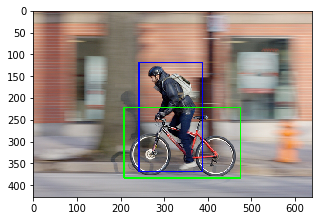

In [61]:
import cv2

def DrawImgWithBBox(rgb_img, human_bbox, obj_bbox, title=None, img_size=(5,5)):
    cv2.rectangle(RGB_img, 
                  (human_bbox[0], human_bbox[2]), 
                  (human_bbox[1], human_bbox[3]), 
                  (0,0,255), 2)

    cv2.rectangle(RGB_img, 
                  (obj_bbox[0], obj_bbox[2]), 
                  (obj_bbox[1], obj_bbox[3]), 
                  (0,255,0), 2)

    fig = plt.figure(figsize=img_size)
    if(title != None):
        plt.title(title)
    plt.imshow(RGB_img)
    plt.show()

action_list = pd.read_csv(os.path.join(HOME_DIR, "HICO/hico_det_dataset/action_list.csv"))

for index, row in df_bat.iterrows():
    print(row['name'])
    img_path = os.path.join(HICO_IMAGE_DIR, row['name'])
    input_img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    human_bbox = row['human_bbox']
    obj_bbox = row['obj_bbox']
    
    gt_action = action_list[action_list['id'] == row['action_no']].iloc[0]
    print('gt: {} / {}'.format(gt_action['verb'], gt_action['object']))
    
    pred_action_ids = row['top_k']
    pred_action_probs = row['top_k_prob']
    for i in range(len(pred_action_ids)):
        pred_action = action_list[action_list['id'] == pred_action_ids[i]].iloc[0]
        print('pred: {} / {} / {}'.format(pred_action['verb'], pred_action['object'], pred_action_probs[i]))

    
    DrawImgWithBBox(RGB_img, 
                    human_bbox, 
                    obj_bbox,
                    img_size=(5,5))